# Enunciado

1) Desarrollar un sistema de recomendación de tipo collaborative filtering.
 En línea con el objetivo planteado para el proyecto, el dataset de entrenamiento y validación del modelo serán aquellos prestadores que muestran altas calificaciones y un nivel de demanda medio y alto. Las altas calificaciones nos aseguran que los prestadores a recomendar brindan un buen servicio. El nivel de demanda medio/alto nos asegura que las calificaciones son representativas estadísticamente. 

# Importación de librerías

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling
import seaborn as sns
import ptitprince as pt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV ,  train_test_split
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import multilabel_confusion_matrix
import operator
import scipy as sp
from sklearn.neighbors import KNeighborsClassifier

pd.options.display.float_format = "{:,.4f}".format

# Importación de datasets

In [82]:
df=pd.read_csv('../Data/df_procesado.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10810 entries, 0 to 10809
Data columns (total 37 columns):
 #   Column                                                                             Non-Null Count  Dtype  
---  ------                                                                             --------------  -----  
 0   id_consumo_encoded                                                                 10810 non-null  int64  
 1   id_socio_encoded                                                                   10810 non-null  int64  
 2   id_prestador_encoded                                                               10810 non-null  int64  
 3   calificacion_experiencia_encoded                                                   10810 non-null  float64
 4   id_zona_encoded                                                                    10810 non-null  int64  
 5   edad_encoded                                                                       10810 non-null  int

In [83]:
df.head(2)

,id_consumo_encoded,id_socio_encoded,id_prestador_encoded,calificacion_experiencia_encoded,id_zona_encoded,edad_encoded,antiguedad_encoded,sexo_encoded_F,sexo_encoded_M,plan_encoded_a,...,edad_cat_3.0,antiguedad_bin_0.0,antiguedad_bin_1.0,antiguedad_bin_2.0,categoria_prestador_gold,categoria_prestador_silver,categoria_prestador_standard,categoria_socio_gold,categoria_socio_silver,categoria_socio_standard
0,1,100000,200000,0.5556,1,81,5.7500,1,0,1,...,1,0,0,1,1,0,0,0,0,1
1,2,100000,200000,0.6667,1,81,5.7500,1,0,1,...,1,0,0,1,1,0,0,0,0,1


In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10810 entries, 0 to 10809
Data columns (total 37 columns):
 #   Column                                                                             Non-Null Count  Dtype  
---  ------                                                                             --------------  -----  
 0   id_consumo_encoded                                                                 10810 non-null  int64  
 1   id_socio_encoded                                                                   10810 non-null  int64  
 2   id_prestador_encoded                                                               10810 non-null  int64  
 3   calificacion_experiencia_encoded                                                   10810 non-null  float64
 4   id_zona_encoded                                                                    10810 non-null  int64  
 5   edad_encoded                                                                       10810 non-null  int

In [85]:
df.rename(columns={'especialidad_prestador_encoded_CLINICA MEDICA':'especialidad_clinica',
                   'especialidad_prestador_encoded_NUTRICIONISTAS(LIC.)                              ':'especialidad_nutricion',
                   'especialidad_prestador_encoded_PEDIATRIA':'especialidad_pediatria'},inplace=True)

### Análisis de demanda de prestadores

Verificamos primero que no se repitan los prestadores entre distintas especialidades

In [86]:
prestadores_clinica=df[df.especialidad_clinica==1].id_prestador_encoded.unique()
prestadores_nutricion=df[df.especialidad_nutricion==1].id_prestador_encoded.unique()
prestadores_pediatria=df[df.especialidad_pediatria==1].id_prestador_encoded.unique()

In [87]:
df[(df.especialidad_clinica==1) &
   ((df.id_prestador_encoded.isin(prestadores_nutricion)) | (df.id_prestador_encoded.isin(prestadores_pediatria)))]

,id_consumo_encoded,id_socio_encoded,id_prestador_encoded,calificacion_experiencia_encoded,id_zona_encoded,edad_encoded,antiguedad_encoded,sexo_encoded_F,sexo_encoded_M,plan_encoded_a,...,edad_cat_3.0,antiguedad_bin_0.0,antiguedad_bin_1.0,antiguedad_bin_2.0,categoria_prestador_gold,categoria_prestador_silver,categoria_prestador_standard,categoria_socio_gold,categoria_socio_silver,categoria_socio_standard


In [88]:
df[(df.especialidad_nutricion==1) & 
   ((df.id_prestador_encoded.isin(prestadores_clinica)) | (df.id_prestador_encoded.isin(prestadores_pediatria)))]

,id_consumo_encoded,id_socio_encoded,id_prestador_encoded,calificacion_experiencia_encoded,id_zona_encoded,edad_encoded,antiguedad_encoded,sexo_encoded_F,sexo_encoded_M,plan_encoded_a,...,edad_cat_3.0,antiguedad_bin_0.0,antiguedad_bin_1.0,antiguedad_bin_2.0,categoria_prestador_gold,categoria_prestador_silver,categoria_prestador_standard,categoria_socio_gold,categoria_socio_silver,categoria_socio_standard


In [89]:
df[(df.especialidad_pediatria==1) & 
   ((df.id_prestador_encoded.isin(prestadores_clinica)) | (df.id_prestador_encoded.isin(prestadores_nutricion)))]

,id_consumo_encoded,id_socio_encoded,id_prestador_encoded,calificacion_experiencia_encoded,id_zona_encoded,edad_encoded,antiguedad_encoded,sexo_encoded_F,sexo_encoded_M,plan_encoded_a,...,edad_cat_3.0,antiguedad_bin_0.0,antiguedad_bin_1.0,antiguedad_bin_2.0,categoria_prestador_gold,categoria_prestador_silver,categoria_prestador_standard,categoria_socio_gold,categoria_socio_silver,categoria_socio_standard


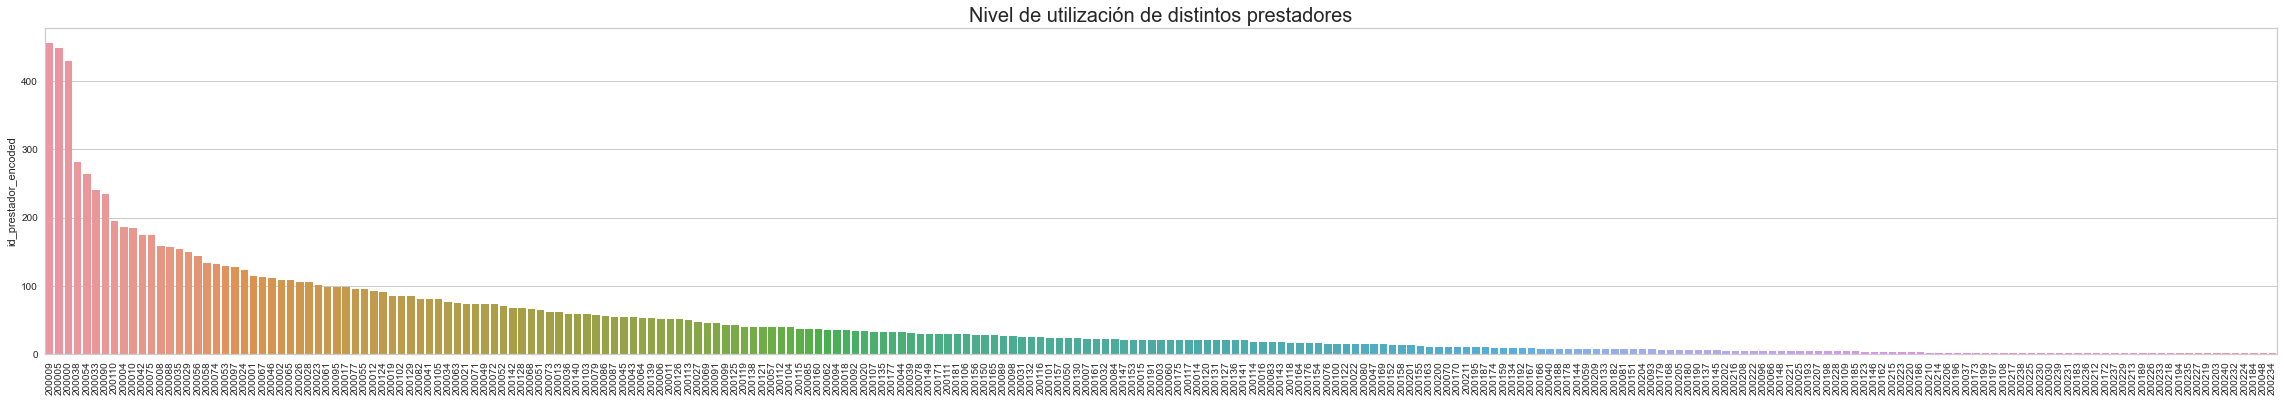

In [90]:
plt.figure(figsize=(40,6))
sns.barplot(x=df.id_prestador_encoded.value_counts().index,y=df.id_prestador_encoded.value_counts(),
           order=df.id_prestador_encoded.value_counts().index)

plt.xticks(rotation=90)
plt.title("Nivel de utilización de distintos prestadores",fontsize=20)
plt.show()

Partiendo del análisis realizado en los laboratorios anteriores, tenemos muchos prestadores que han sido utilizados pocas veces, mientras que hay pocos que han sido utilizados muchas veces.
Vamos a hacer una selección basándonos en medidas de tendencia central de la distribución anterior

In [91]:
df.id_prestador_encoded.value_counts().describe().reset_index()

,index,id_prestador_encoded
0,count,241.0000
1,mean,44.8548
2,std,67.7667
3,min,1.0000
4,25%,6.0000
5,50%,21.0000
6,75%,56.0000
7,max,455.0000


Vamos a filtrar utilizando el percentil 0.2

In [92]:
percetil_42=df.id_prestador_encoded.value_counts().quantile(0.2)
prestadores_interes=df.id_prestador_encoded.value_counts()[df.id_prestador_encoded.value_counts()>percetil_42].index

In [93]:
df_filtrado=df[df.id_prestador_encoded.isin(prestadores_interes)]
df_filtrado.shape

(10713, 37)

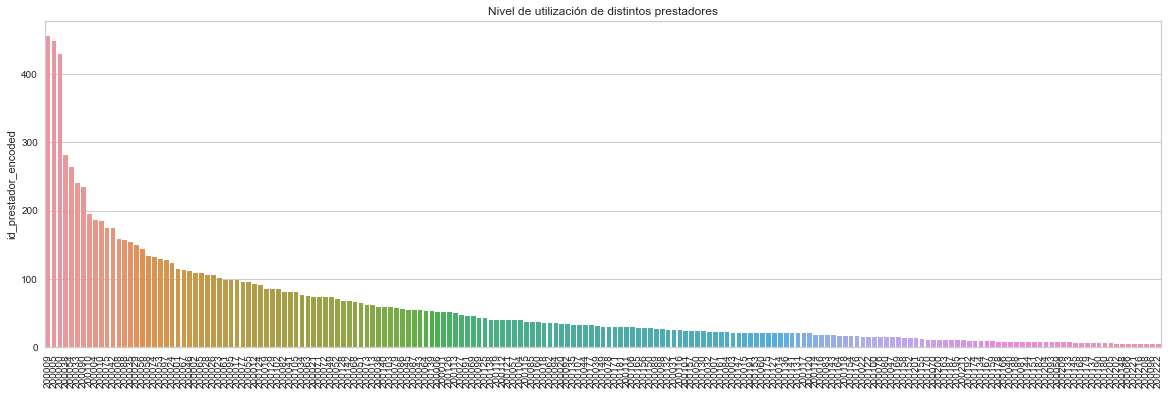

In [94]:
plt.figure(figsize=(20,6))
sns.barplot(x=df_filtrado.id_prestador_encoded.value_counts().index,y=df_filtrado.id_prestador_encoded.value_counts(),
           order=df_filtrado.id_prestador_encoded.value_counts().index)

plt.xticks(rotation=90)
plt.title("Nivel de utilización de distintos prestadores")
plt.show()

### Análisis de consumos de los socios

Para poder hacer un filtro colaborativo, es necesario encontrar similitudes en los consumos de los diferentes socios.

In [95]:
df_consumos=pd.read_csv('../Data/tabla_consumos_ampliada.csv')
df_consumos.head(2)

,id_consumo_encoded,id_nomenclador_encoded,id_socio_encoded,id_prestador_encoded,descripcion_practica_encoded,calificacion_experiencia_encoded
0,1,11111,100000,200000,ATENCION ON LINE COVID19 ...,6
1,2,11111,100000,200000,ATENCION ON LINE COVID19 ...,7


In [96]:
df_socios_grouped=df_consumos[['id_socio_encoded','id_prestador_encoded']].drop_duplicates()

In [97]:
df_socios_grouped

,id_socio_encoded,id_prestador_encoded
0,100000,200000
2,100001,200001
3,100002,200000
4,100003,200002
5,100004,200003
...,...,...
10803,108388,200009
10805,108389,200110
10806,108390,200000
10807,108391,200129


In [98]:
columns={'id_prestador_encoded':'cantidad_prestadores'}
df_socios_grouped=df_socios_grouped.groupby(['id_socio_encoded'])['id_prestador_encoded'].count().reset_index().rename(columns=columns)
df_socios_grouped.sort_values('cantidad_prestadores',ascending=False)

,id_socio_encoded,cantidad_prestadores
6507,106507,2
2853,102853,2
1444,101444,2
7543,107543,2
4139,104139,2
...,...,...
2798,102798,1
2797,102797,1
2796,102796,1
2795,102795,1


In [99]:
df_filtrado[df_filtrado.id_socio_encoded==104139]

,id_consumo_encoded,id_socio_encoded,id_prestador_encoded,calificacion_experiencia_encoded,id_zona_encoded,edad_encoded,antiguedad_encoded,sexo_encoded_F,sexo_encoded_M,plan_encoded_a,...,edad_cat_3.0,antiguedad_bin_0.0,antiguedad_bin_1.0,antiguedad_bin_2.0,categoria_prestador_gold,categoria_prestador_silver,categoria_prestador_standard,categoria_socio_gold,categoria_socio_silver,categoria_socio_standard
2960,5326,104139,200024,0.8889,1,56,2.4167,1,0,0,...,1,0,1,0,1,0,0,0,0,1
7589,5325,104139,200088,1.0000,1,56,2.4167,1,0,0,...,1,0,1,0,1,0,0,0,0,1


Text(0.5, 1.0, 'Variabilidad en los prestadores por socio')

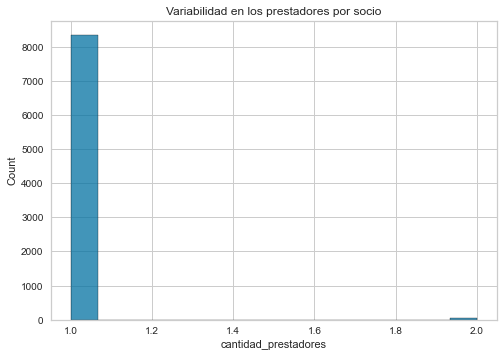

In [100]:
fig,axs=plt.subplots(1,1)
sns.histplot(df_socios_grouped.cantidad_prestadores,ax=axs)
plt.title("Variabilidad en los prestadores por socio")

La gran mayoría de pacientes que ha consumido a un solo médico. Por ejemplo, si el socio 101923 consumió el mismo médico que 100725, y este último no consumió otro distinto..¿que médico puedo recomendar?. Deberé quedarme con los pacientes que tengan médicos que aparezcan en otros pacientes con mayor número de prestadores distintos.

In [101]:
df_socios_grouped[df_socios_grouped.cantidad_prestadores>1]

,id_socio_encoded,cantidad_prestadores
215,100215,2
262,100262,2
296,100296,2
989,100989,2
1042,101042,2
1168,101168,2
1352,101352,2
1444,101444,2
1740,101740,2
1905,101905,2


In [102]:
df_socios_grouped[df_socios_grouped.cantidad_prestadores>1].shape

(50, 2)

In [103]:
df_consumos.id_socio_encoded.nunique()

8393

Sin embargo tenemos solamente 50 pacientes que han consumido mas de un prestador de un total de 8393. El abordaje de filtro colaborativo no tiene sentido en este aspecto, por lo que se tendrá que hacer un sistema de recomendación manual.

In [104]:
df_consumos.descripcion_practica_encoded.value_counts()

ATENCION ON LINE COVID19                                                                                                    10810
Name: descripcion_practica_encoded, dtype: int64

In [105]:
clientes_masdeunprestador=df_socios_grouped[df_socios_grouped.cantidad_prestadores>1].id_socio_encoded
clientes_masdeunprestador.shape

(50,)

In [106]:
df_filtrado[df_filtrado.id_socio_encoded.isin(clientes_masdeunprestador)].sort_values('id_prestador_encoded')

,id_consumo_encoded,id_socio_encoded,id_prestador_encoded,calificacion_experiencia_encoded,id_zona_encoded,edad_encoded,antiguedad_encoded,sexo_encoded_F,sexo_encoded_M,plan_encoded_a,...,edad_cat_3.0,antiguedad_bin_0.0,antiguedad_bin_1.0,antiguedad_bin_2.0,categoria_prestador_gold,categoria_prestador_silver,categoria_prestador_standard,categoria_socio_gold,categoria_socio_silver,categoria_socio_standard
362,8836,106846,200000,0.5556,4,42,5.0833,1,0,0,...,0,0,0,1,1,0,0,0,0,1
458,2259,101740,200001,0.7778,20,65,4.0833,1,0,1,...,1,0,0,1,1,0,0,0,0,1
826,8399,106507,200004,0.8889,4,24,0.2500,1,0,0,...,0,1,0,0,1,0,0,0,0,1
845,9789,107592,200004,0.7778,9,17,2.6667,1,0,0,...,0,0,1,0,1,0,0,0,0,1
1324,3748,102910,200006,0.4444,3,38,3.7500,0,1,0,...,0,0,0,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9575,4430,103446,200129,0.8889,1,47,4.4167,1,0,1,...,1,0,0,1,1,0,0,0,1,0
9576,4431,103446,200129,1.0000,1,47,4.4167,1,0,1,...,1,0,0,1,1,0,0,0,1,0
9618,9729,107543,200129,0.7778,4,63,5.5833,1,0,1,...,1,0,0,1,1,0,0,0,0,1
9837,6603,105114,200139,0.3333,4,31,0.0833,1,0,0,...,0,1,0,0,1,0,0,0,0,1


### Análisis de calificaciones

C:\Users\arrua\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


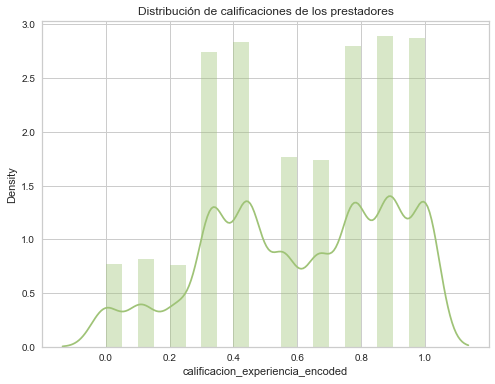

In [107]:
plt.figure(figsize=(8,6))
sns.distplot(df_filtrado.calificacion_experiencia_encoded,color='g')
plt.title("Distribución de calificaciones de los prestadores")
plt.show()

In [108]:
df_filtrado.calificacion_experiencia_encoded.describe().reset_index()

,index,calificacion_experiencia_encoded
0,count,"10,713.0000"
1,mean,0.6098
2,std,0.2868
3,min,0.0000
4,25%,0.3333
5,50%,0.6667
6,75%,0.8889
7,max,1.0000


Vamos a filtrar utilizando el percentil 0.4

In [109]:
percentil_0405=df_filtrado.calificacion_experiencia_encoded.quantile(0.4)

In [110]:
df_filtrado=df_filtrado[df_filtrado.calificacion_experiencia_encoded>percentil_0405]

In [111]:
df_filtrado.shape

(5518, 37)

Nos quedamos con un total de 1297 registros de pacientes para las 3 especialidades. Este grupo de datos considera a los prestadores mas demandados y que posean calificaciones más aceptables.

## Filtrado de variables no importantes

En un primer análisis se tendrán en cuenta todas las variables adicionales. Solamente se quitarán las que no son necesarias para el proceso de modelado

In [112]:
df_filtrado.columns

Index(['id_consumo_encoded', 'id_socio_encoded', 'id_prestador_encoded',
       'calificacion_experiencia_encoded', 'id_zona_encoded', 'edad_encoded',
       'antiguedad_encoded', 'sexo_encoded_F', 'sexo_encoded_M',
       'plan_encoded_a', 'plan_encoded_b', 'plan_encoded_c',
       'segmento_encoded_empresa_tipo_1', 'segmento_encoded_empresa_tipo_2',
       'segmento_encoded_individuo_tipo_1',
       'segmento_encoded_individuo_tipo_2',
       'segmento_encoded_individuo_tipo_3', 'parentesco_encoded_Otro',
       'parentesco_encoded_Titular', 'app_descargada_encoded_NO',
       'app_descargada_encoded_SI', 'especialidad_clinica',
       'especialidad_nutricion', 'especialidad_pediatria', 'edad_cat_0.0',
       'edad_cat_1.0', 'edad_cat_2.0', 'edad_cat_3.0', 'antiguedad_bin_0.0',
       'antiguedad_bin_1.0', 'antiguedad_bin_2.0', 'categoria_prestador_gold',
       'categoria_prestador_silver', 'categoria_prestador_standard',
       'categoria_socio_gold', 'categoria_socio_silver',
    

In [113]:
df_filtrado.drop(['id_consumo_encoded','edad_encoded','antiguedad_encoded'],axis=1,inplace=True)

In [114]:
df_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5518 entries, 1 to 9624
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   id_socio_encoded                   5518 non-null   int64  
 1   id_prestador_encoded               5518 non-null   int64  
 2   calificacion_experiencia_encoded   5518 non-null   float64
 3   id_zona_encoded                    5518 non-null   int64  
 4   sexo_encoded_F                     5518 non-null   int64  
 5   sexo_encoded_M                     5518 non-null   int64  
 6   plan_encoded_a                     5518 non-null   int64  
 7   plan_encoded_b                     5518 non-null   int64  
 8   plan_encoded_c                     5518 non-null   int64  
 9   segmento_encoded_empresa_tipo_1    5518 non-null   int64  
 10  segmento_encoded_empresa_tipo_2    5518 non-null   int64  
 11  segmento_encoded_individuo_tipo_1  5518 non-null   int64

In [115]:
columnas_eliminar=['categoria_socio_silver','categoria_socio_standard','id_prestador_encoded','id_prestador_encoded',
                   'categoria_prestador_silver','categoria_prestador_standard','categoria_prestador_gold'
                   ,'calificacion_experiencia_encoded','app_descargada_encoded_NO','id_prestador_encoded',
                   'parentesco_encoded_Otro','sexo_encoded_F','segmento_encoded_empresa_tipo_2','categoria_socio_gold']

# SOM

Se utilizarán Self Organizing maps para hacer clustering. Esta técnica también nos permite hacer una apreciación visual de los clusters siguiendo una variable objetivo.

In [116]:
df_som=df_filtrado.drop(columnas_eliminar,axis=1).drop_duplicates()
df_som=pd.get_dummies(df_som, columns=['id_zona_encoded'])
df_som.shape

(4172, 48)

In [117]:
df_som.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4172 entries, 1 to 9624
Data columns (total 48 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   id_socio_encoded                   4172 non-null   int64
 1   sexo_encoded_M                     4172 non-null   int64
 2   plan_encoded_a                     4172 non-null   int64
 3   plan_encoded_b                     4172 non-null   int64
 4   plan_encoded_c                     4172 non-null   int64
 5   segmento_encoded_empresa_tipo_1    4172 non-null   int64
 6   segmento_encoded_individuo_tipo_1  4172 non-null   int64
 7   segmento_encoded_individuo_tipo_2  4172 non-null   int64
 8   segmento_encoded_individuo_tipo_3  4172 non-null   int64
 9   parentesco_encoded_Titular         4172 non-null   int64
 10  app_descargada_encoded_SI          4172 non-null   int64
 11  especialidad_clinica               4172 non-null   int64
 12  especialidad_nutrici

In [118]:
df_som_test=df_som.sample(200,random_state=0).drop_duplicates()

In [119]:
df_som_test

,id_socio_encoded,sexo_encoded_M,plan_encoded_a,plan_encoded_b,plan_encoded_c,segmento_encoded_empresa_tipo_1,segmento_encoded_individuo_tipo_1,segmento_encoded_individuo_tipo_2,segmento_encoded_individuo_tipo_3,parentesco_encoded_Titular,...,id_zona_encoded_18,id_zona_encoded_19,id_zona_encoded_20,id_zona_encoded_21,id_zona_encoded_22,id_zona_encoded_23,id_zona_encoded_24,id_zona_encoded_25,id_zona_encoded_27,id_zona_encoded_28
1028,103487,1,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1224,106832,1,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8906,108064,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
8265,106540,0,0,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2809,101577,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5233,101070,0,1,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
9572,102952,0,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5549,106543,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3067,104507,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [120]:
df_som_train=df_som[~df_som.index.isin(df_som_test.index)]

In [121]:
df_som_train.set_index('id_socio_encoded',inplace=True)
df_som_test.set_index('id_socio_encoded',inplace=True)

In [122]:
df_som_train.shape

(3972, 47)

In [123]:
df_som_train.head(2)

,sexo_encoded_M,plan_encoded_a,plan_encoded_b,plan_encoded_c,segmento_encoded_empresa_tipo_1,segmento_encoded_individuo_tipo_1,segmento_encoded_individuo_tipo_2,segmento_encoded_individuo_tipo_3,parentesco_encoded_Titular,app_descargada_encoded_SI,...,id_zona_encoded_18,id_zona_encoded_19,id_zona_encoded_20,id_zona_encoded_21,id_zona_encoded_22,id_zona_encoded_23,id_zona_encoded_24,id_zona_encoded_25,id_zona_encoded_27,id_zona_encoded_28
id_socio_encoded,,,,,,,,,,,,,,,,,,,,,
100000,0,1,0,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
100002,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Determinación del número óptimo de clusters

A continuación determinamos el número optimo de clusters utilizando el método del codo y Silhouette.

In [124]:
# Preparamos una lista donde vamos a ir agregando las distancias medias
lista_distancias_medias = []
# Entrenamos un modelo para cada numero de cluster que queremos testear
K = np.arange(2,16)
for k in K:
    # Definimos y entrenamos el modelo
    km = KMeans(n_clusters=k)
    km = km.fit(df_som_train)
    # Tomamos la suma de las distancias para todas las instancias del dataset
    distancia_total = km.inertia_
    # Calculamos la distancia media y agregamos a la lista
    distancia_media = distancia_total/df_som_train.shape[0]
    lista_distancias_medias.append(distancia_media)

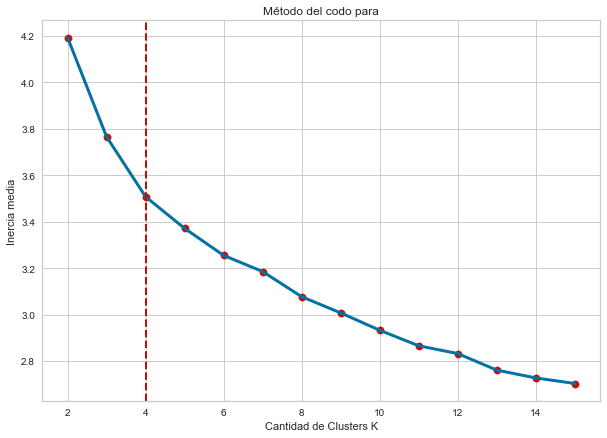

In [125]:
plt.figure(figsize = (10,7))
# Graficamos una linea continua y tambien unos puntos para resaltar los valores enteros de K.
plt.plot(K,lista_distancias_medias, lw=3)
plt.scatter(K,lista_distancias_medias,s=55,c='r')
plt.axvline(x=4,linewidth=2,linestyle="--", color='r')
plt.xlabel('Cantidad de Clusters K')
plt.ylabel('Inercia media')
plt.title('Método del codo para')

plt.show()

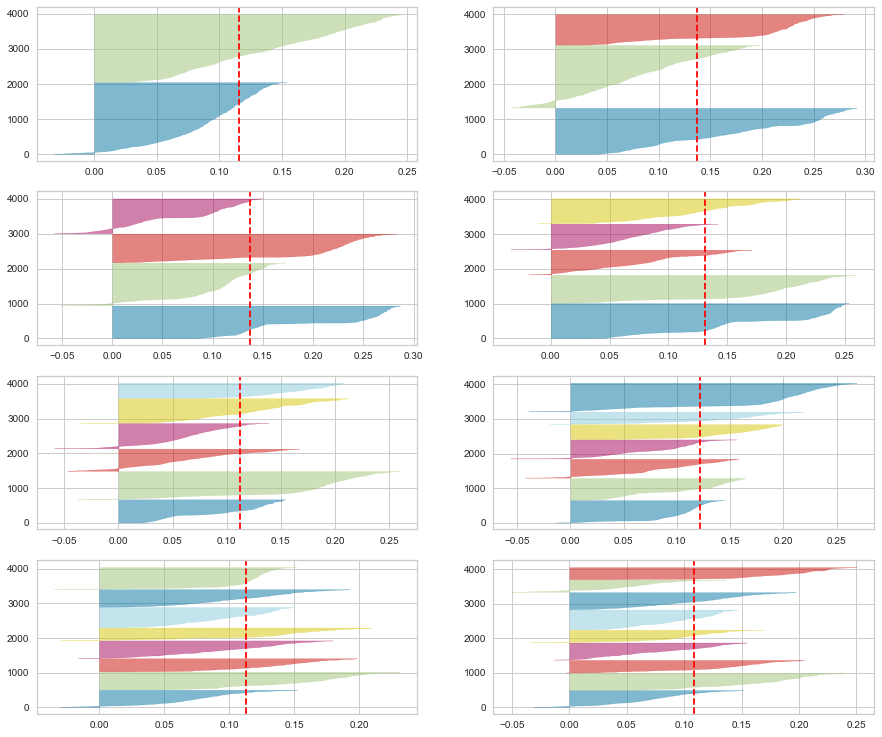

In [126]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(4, 2, figsize=(15,13))
for i in [2, 3, 4, 5,6,7,8,9]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df_som_train)

Aparentemente 4 es el número optimo de clústeres según ambas técnicas elegidas. Sin embargo, al hacer un análisis de segmentación de clientes, es esperable que los métodos no nos proporcionen una clara definición de las fronteras entre los socios . Probablemente sea mejor conseguir variables representativas del negocio para hacer una diferenciación según algun objetivo o característica.

In [127]:
class SOM():
    
    def __init__(self, n_rows, n_columns,lr=0.5,learning_rate=None):
        
 
        self.n_rows = n_rows
        self.n_columns = n_columns
        self.learning_rate=learning_rate if learning_rate is not None else lr
    
    
    def train_predict(self,data):
        
            from minisom import MiniSom
            
            self.data=data.copy()
    
            som = MiniSom(self.n_rows,self.n_columns, self.data.shape[1],learning_rate=self.learning_rate ,sigma=2.,  
                          neighborhood_function='gaussian', random_seed=10)
            som.pca_weights_init(data.values)
            print("Training...")
            som.train_batch(self.data.values, 50000, verbose=True)  # random training
            print("\n...ready!")
            
            self.som=som
            
            winner_coordinates = np.array([self.som.winner(x) for x in self.data.values]).T
            
            self.cluster_index = np.ravel_multi_index(winner_coordinates, (self.n_rows,self.n_columns))
            
            self.labels_maps=som.labels_map(self.data.values, [t for t in self.cluster_index])
            
            self.win_map = self.som.win_map(self.data.values)

            self.data['cluster_index']=self.cluster_index
            
            return np.concatenate(self.som.get_weights())

    
    def color_categorica(self,data_clientes,variable_cat):
        
            from sklearn.preprocessing import MinMaxScaler     
                    
            matrix=np.zeros((self.n_rows,self.n_columns))
    
            for position in self.labels_maps.keys():

                cluster_som=int(list(self.labels_maps[position].keys())[0])
                matrix[position[0],position[1]]=self.data_clientes[self.data_clientes.cluster_index==cluster_som][self.variable_cat].mean()

            flat_matrix=matrix.flatten()
            
            scaler=MinMaxScaler()
            new_matrix=scaler.fit_transform(flat_matrix.reshape(-1,1))

            self.new_matrix=new_matrix.reshape(self.n_rows,self.n_columns)
            
    def plot(self,data_clientes,variable_cat,figsize):
        
        import matplotlib.gridspec as gridspec
        from matplotlib import cm, colorbar
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        from matplotlib.offsetbox import AnchoredText
        
        self.data_clientes=data_clientes.copy()
        self.variable_cat=variable_cat
        
        self.data_clientes=self.data_clientes.merge(self.data[['cluster_index']],right_index=True,left_index=True,how='left')
        
        
        self.color_categorica(self.data_clientes,self.variable_cat)
        
        fig,axs=plt.subplots(nrows=self.n_rows,ncols=self.n_columns,sharex=True,figsize=figsize,sharey=True)
        
        fig.suptitle(self.variable_cat,fontsize=13)
        fig.tight_layout()
    
        for position in self.labels_maps.keys():

            cluster_som=int(list(self.labels_maps[position].keys())[0])

#             axs2 = axs[position[0],position[1]].twinx().twiny()
            
            columns=self.data.columns[:-1]

            axs[position[0],position[1]].plot(columns,np.mean(self.win_map[position], axis=0),color='lime',marker='.',markersize=10)
            
            axs[position[0],position[1]].axhline(y=0, color='tab:gray', linestyle='-')
            
            axs[position[0],position[1]].set_xticklabels(rotation=90,labels=columns)

            axs[position[0],position[1]].set_facecolor(cm.Blues(self.new_matrix[position[0], position[1]]))
            
            axs[position[0],position[1]].grid()
            
            axs[position[0],position[1]].set_title(cluster_som)

#             axs2.hist(self.data_clientes.margen_porcentual,bins=int(np.sqrt(self.data_clientes[self.data_clientes.cluster_index==cluster_som].shape[0])),
#                                                color='tab:orange')
            
            anchored_text = AnchoredText('Clientes:{} \nMean {}:{:.3f}'.format(self.data_clientes[self.data_clientes.cluster_index==cluster_som].index.nunique(),
                                                                           self.variable_cat,
                                                                               (self.data_clientes[self.data_clientes.cluster_index==cluster_som][self.variable_cat].mean())),
                                         loc=2)
            axs[position[0],position[1]].add_artist(anchored_text)
            
        return self.data_clientes,self.data
    
    def predict(self,x):
        
        winner_coordinates = np.array([self.som.winner(x) for x in x.values]).T
            
        cluster_index = np.ravel_multi_index(winner_coordinates, (self.n_rows,self.n_columns))
        
        return cluster_index

In [128]:
som=SOM(2,2)

In [129]:
centroides=som.train_predict(df_som_train)

C:\Users\arrua\anaconda3\lib\site-packages\minisom.py:154: UserWarning: Warning: sigma is too high for the dimension of the map.
  warn('Warning: sigma is too high for the dimension of the map.')


Training...
 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 2.2406863032064424

...ready!


## Dataframe con datos de clientes

In [130]:
df_data_socios=df[['id_socio_encoded','edad_encoded','antiguedad_encoded','calificacion_experiencia_encoded']].drop_duplicates()

In [131]:
df_data_socios

,id_socio_encoded,edad_encoded,antiguedad_encoded,calificacion_experiencia_encoded
0,100000,81,5.7500,0.5556
1,100000,81,5.7500,0.6667
2,100002,60,6.3333,0.6667
3,100010,43,5.6667,0.5556
4,100017,47,5.8333,0.5556
...,...,...,...,...
10805,107588,9,1.9167,0.1111
10806,107605,53,6.0833,0.2222
10807,107868,32,2.5833,0.0000
10808,108136,11,3.1667,0.0000


In [132]:
df_data_socios.id_socio_encoded.duplicated().sum()

1294

Se hace un groupby para obtener los últimos valores de cada socio

In [133]:
df_data_socios=df_data_socios.groupby('id_socio_encoded').agg({
                                                                'edad_encoded':'last',
                                                                'antiguedad_encoded':'last',
                                                                'calificacion_experiencia_encoded':'mean'
                                                                })

In [134]:
df_data_socios

,edad_encoded,antiguedad_encoded,calificacion_experiencia_encoded
id_socio_encoded,,,
100000,81,5.7500,0.6111
100001,64,6.4167,0.8889
100002,60,6.3333,0.6667
100003,49,6.5000,1.0000
100004,48,5.5000,0.0000
...,...,...,...
108388,48,1.3333,0.6111
108389,1,0.6667,0.8889
108390,55,0.6667,0.6667


In [135]:
df_som_train.shape

(3972, 47)

In [136]:
df_info_clientes=df_som_train.merge(df_data_socios,left_index=True,right_on='id_socio_encoded',how='left')
df_info_clientes

,sexo_encoded_M,plan_encoded_a,plan_encoded_b,plan_encoded_c,segmento_encoded_empresa_tipo_1,segmento_encoded_individuo_tipo_1,segmento_encoded_individuo_tipo_2,segmento_encoded_individuo_tipo_3,parentesco_encoded_Titular,app_descargada_encoded_SI,...,id_zona_encoded_21,id_zona_encoded_22,id_zona_encoded_23,id_zona_encoded_24,id_zona_encoded_25,id_zona_encoded_27,id_zona_encoded_28,edad_encoded,antiguedad_encoded,calificacion_experiencia_encoded
id_socio_encoded,,,,,,,,,,,,,,,,,,,,,
100000,0,1,0,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,81,5.7500,0.6111
100002,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,60,6.3333,0.6667
100017,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,47,5.8333,0.6111
100028,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,65,4.7500,0.6667
100312,1,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,63,5.1667,0.6667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107557,0,1,0,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,41,2.6667,0.8333
107759,1,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,34,3.8333,0.7778
107861,0,0,1,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,46,0.7500,0.8889


A continuación vemos como la técnica adoptada separa a los clusters por las variables edad, calificación y antiguedad:

<ipython-input-127-d08e964b205a>:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[position[0],position[1]].set_xticklabels(rotation=90,labels=columns)
<ipython-input-127-d08e964b205a>:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[position[0],position[1]].set_xticklabels(rotation=90,labels=columns)
<ipython-input-127-d08e964b205a>:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[position[0],position[1]].set_xticklabels(rotation=90,labels=columns)
<ipython-input-127-d08e964b205a>:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[position[0],position[1]].set_xticklabels(rotation=90,labels=columns)


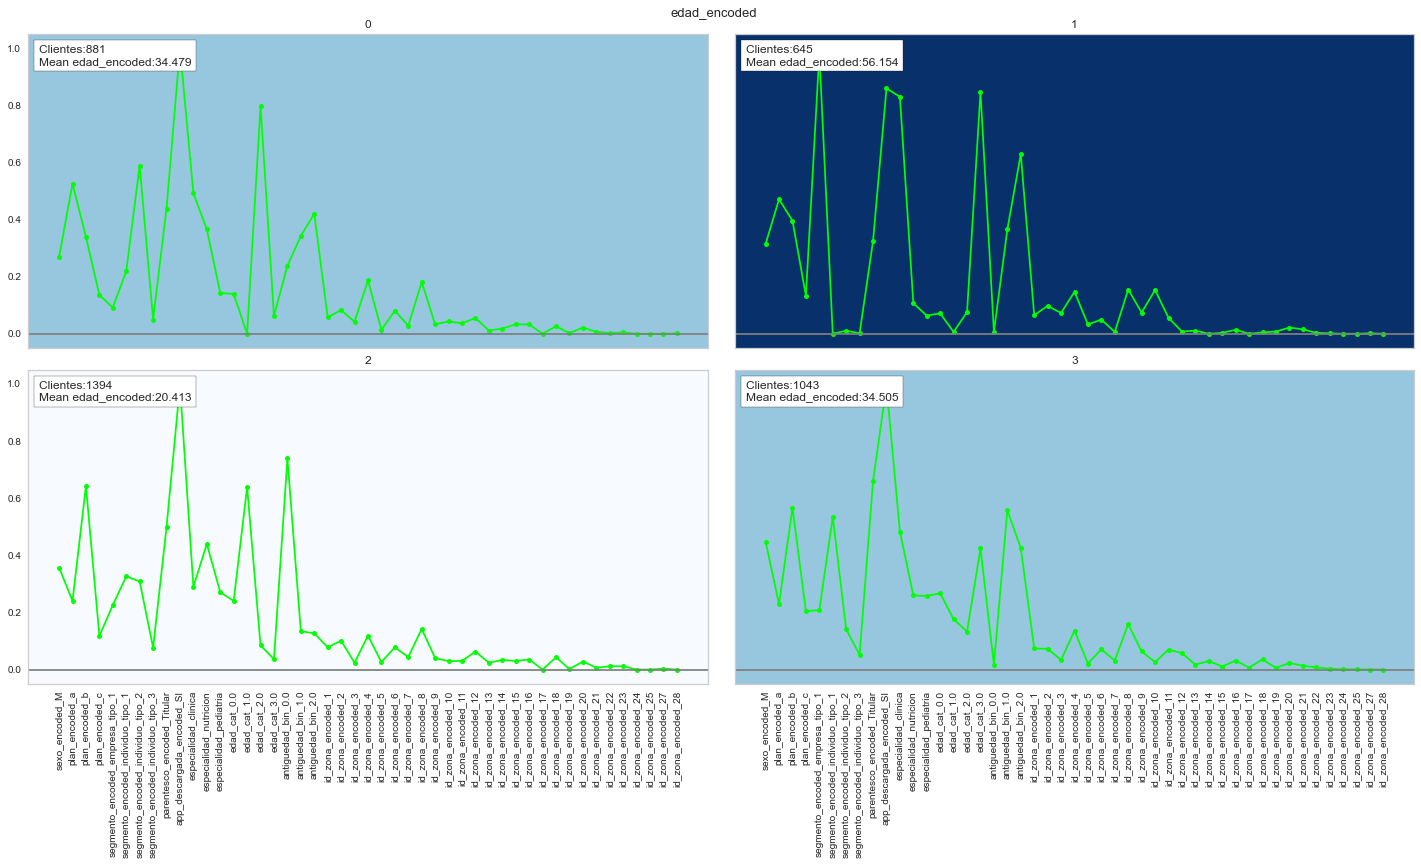

In [137]:
data_socios,data=som.plot(df_info_clientes,'edad_encoded',(20,10))

<ipython-input-127-d08e964b205a>:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[position[0],position[1]].set_xticklabels(rotation=90,labels=columns)
<ipython-input-127-d08e964b205a>:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[position[0],position[1]].set_xticklabels(rotation=90,labels=columns)
<ipython-input-127-d08e964b205a>:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[position[0],position[1]].set_xticklabels(rotation=90,labels=columns)
<ipython-input-127-d08e964b205a>:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[position[0],position[1]].set_xticklabels(rotation=90,labels=columns)


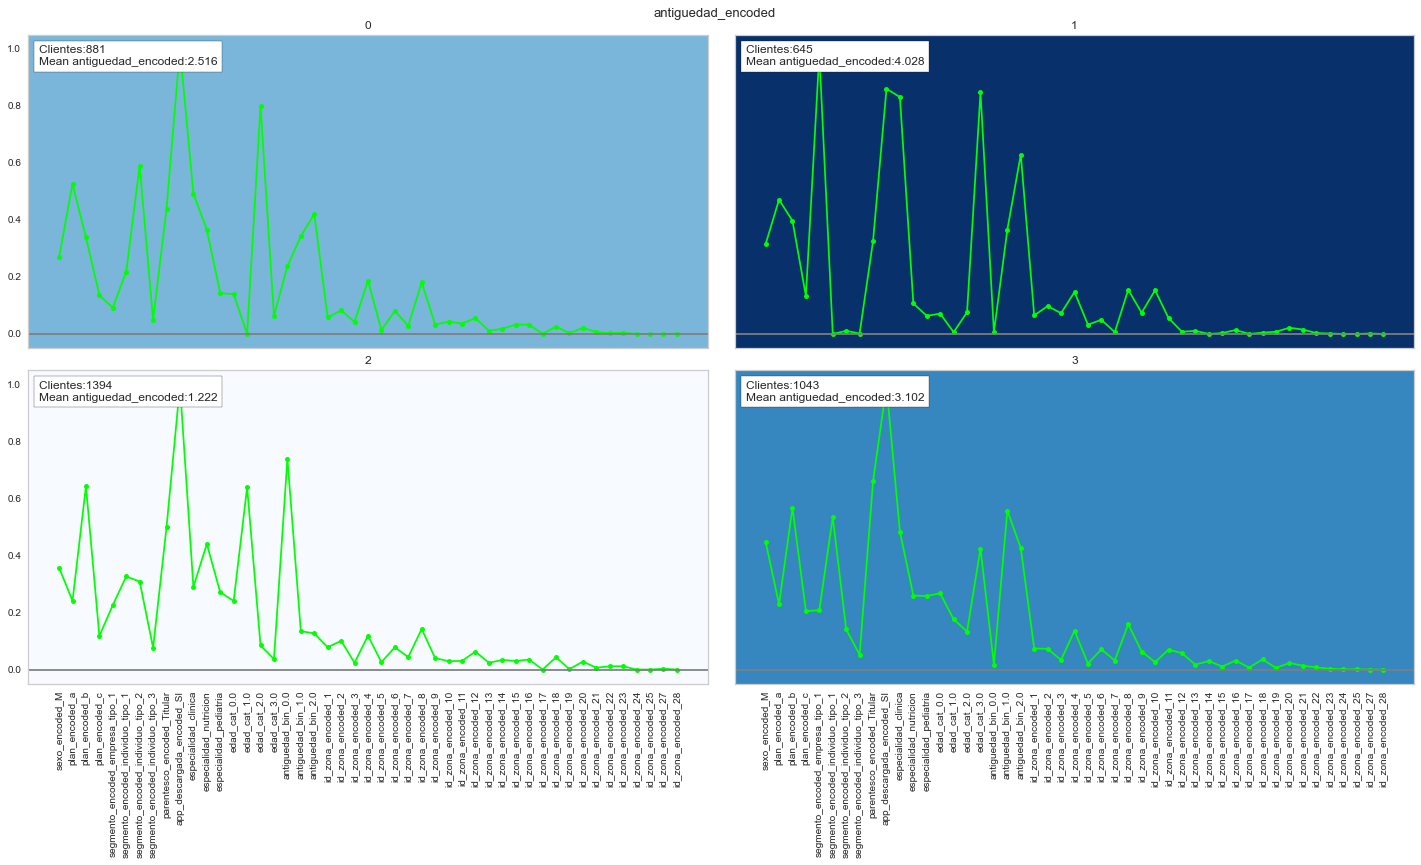

In [138]:
data_socios,data=som.plot(df_info_clientes,'antiguedad_encoded',(20,10))

<ipython-input-127-d08e964b205a>:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[position[0],position[1]].set_xticklabels(rotation=90,labels=columns)
<ipython-input-127-d08e964b205a>:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[position[0],position[1]].set_xticklabels(rotation=90,labels=columns)
<ipython-input-127-d08e964b205a>:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[position[0],position[1]].set_xticklabels(rotation=90,labels=columns)
<ipython-input-127-d08e964b205a>:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[position[0],position[1]].set_xticklabels(rotation=90,labels=columns)


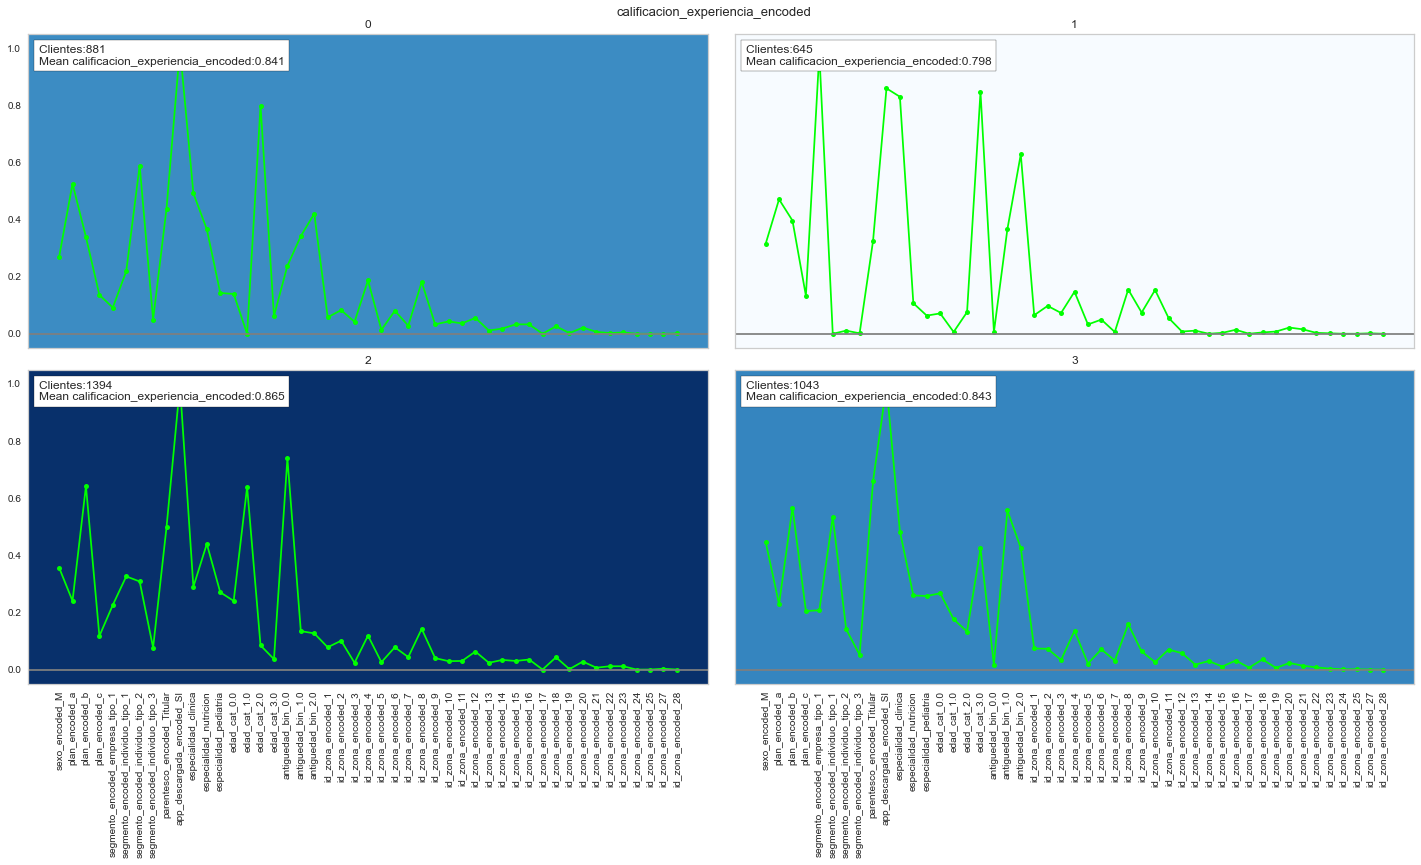

In [139]:
data_socios,data=som.plot(df_info_clientes,'calificacion_experiencia_encoded',(20,10))

# Evaluación del modelo

A continuación vamos a predecir el cluster asignado a cada uno de los socios separados para el conjunto de testeo

In [140]:
df_som_test['prediccion']=som.predict(df_som_test)

In [141]:
df_som_test

,sexo_encoded_M,plan_encoded_a,plan_encoded_b,plan_encoded_c,segmento_encoded_empresa_tipo_1,segmento_encoded_individuo_tipo_1,segmento_encoded_individuo_tipo_2,segmento_encoded_individuo_tipo_3,parentesco_encoded_Titular,app_descargada_encoded_SI,...,id_zona_encoded_19,id_zona_encoded_20,id_zona_encoded_21,id_zona_encoded_22,id_zona_encoded_23,id_zona_encoded_24,id_zona_encoded_25,id_zona_encoded_27,id_zona_encoded_28,prediccion
id_socio_encoded,,,,,,,,,,,,,,,,,,,,,
103487,1,0,1,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,1
106832,1,0,1,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,3
108064,0,0,1,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
106540,0,0,1,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
101577,1,1,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101070,0,1,0,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,2
102952,0,1,0,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1
106543,0,1,0,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0


Para cada paciente, obtendremos una lista de prestadores que dependerán del cluster asignado. A su vez, dentro de cada cluster se encontrarán los socios mas cercanos al buscado para encontrar una lista de n prestadores a recomendar.  La siguiente función se encarga de evaluar la distancia del socio a los socios mas cercados y devuelve una métrica que cuantific la distancia al prestador que fue realmente seleccionado por el socio consultado.

In [144]:
from scipy.spatial import distance

mrrs=[]
ranking_menor_5=[]

for socio in df_som_test.index.unique():
    
    #Para cada socio, buscamos el cluster predicho y los features. También extraemos el prestador real
    
    cluster_socio=df_som_test[df_som_test.index==socio].prediccion.values[0]
    
    data_cliente=df_som_test[df_som_test.index==socio].values[0]
    
    data_cliente=data_cliente[:-1]
    
    prestador_real=df_filtrado[df_filtrado.id_socio_encoded==socio].id_prestador_encoded.values[0]
    
    print("El socio {} tuvo como prestador real: {}".format(socio,prestador_real))
    
    #Vemos los clientes que se encuentran en ese array
    
    data_clientes_cluster=data[data.cluster_index==cluster_socio]
    
    data_clientes_cluster=data_clientes_cluster[data_clientes_cluster.columns[:-1]]
    
    #Evaluamos la distancia de Jaccard del cliente a cada uno de los clientes del cluster
    
    distancias=distance.cdist(data_clientes_cluster.values,data_cliente.reshape(1,-1),metric='jaccard')
    
    data_clientes_cluster['distancia']=distancias
    
    #Mientras mas pequeña sea la distancia, mas similares son los socios
    
    clientes_similares=data_clientes_cluster.sort_values('distancia').index
    
    prestadores_similares=df_filtrado[df_filtrado.id_socio_encoded.isin(clientes_similares)].id_prestador_encoded.unique().tolist()
    
    if prestador_real in prestadores_similares:
        
        ranking_prestador=prestadores_similares.index(prestador_real)+1
        mrr=1/ranking_prestador
        mrrs.append(mrr)
        print("El prestador esta en el lugar número {} - Mean reciprocal ranking= {}".format(ranking_prestador,mrr))
    
    else:
        
        print("Prestador no encontrado")
        mrrs.append(0)
        
print("MEAN MRR: {}".format(np.mean(mrrs)))



El socio 103487 tuvo como prestador real: 200005
El prestador esta en el lugar número 5 - Mean reciprocal ranking= 0.2
El socio 106832 tuvo como prestador real: 200005
El prestador esta en el lugar número 5 - Mean reciprocal ranking= 0.2
El socio 108064 tuvo como prestador real: 200110
El prestador esta en el lugar número 38 - Mean reciprocal ranking= 0.02631578947368421
El socio 106540 tuvo como prestador real: 200097
El prestador esta en el lugar número 36 - Mean reciprocal ranking= 0.027777777777777776
El socio 101577 tuvo como prestador real: 200023
El prestador esta en el lugar número 12 - Mean reciprocal ranking= 0.08333333333333333
El socio 102949 tuvo como prestador real: 200009
El prestador esta en el lugar número 7 - Mean reciprocal ranking= 0.14285714285714285
El socio 108195 tuvo como prestador real: 200009
El prestador esta en el lugar número 7 - Mean reciprocal ranking= 0.14285714285714285
El socio 102843 tuvo como prestador real: 200035
El prestador esta en el lugar núme